# Test with trajectory_lstm_model_batched.h5

/home/sumo/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 0 - Reward: -13.76
Episode 50 - Reward: -20.81
Episode 100 - Reward: -13.55
Episode 150 - Reward: -9.36
Episode 200 - Reward: -5.92
Episode 250 - Reward: -19.42
Episode 300 - Reward: -5.34
Episode 350 - Reward: -4.25
Episode 400 - Reward: -7.27
Episode 450 - Reward: -3.02
Episode 500 - Reward: -5.15
Episode 550 - Reward: -18.89
Episode 600 - Reward: -27.13
Episode 650 - Reward: -24.40
Episode 700 - Reward: -3.02
Episode 750 - Reward: -3.02
Episode 800 - Reward: -3.02
Episode 850 - Reward: -5.34
Episode 900 - Reward: -3.02
Episode 950 - Reward: -3.02


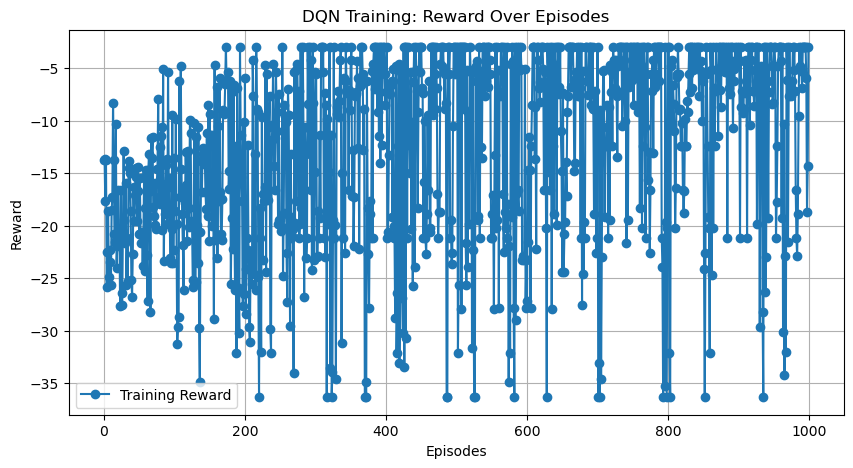

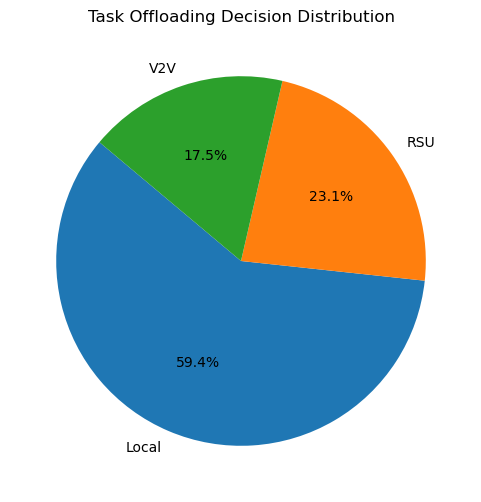

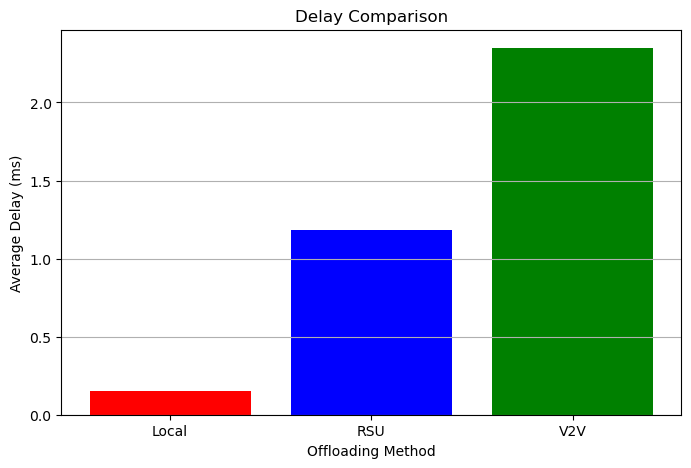

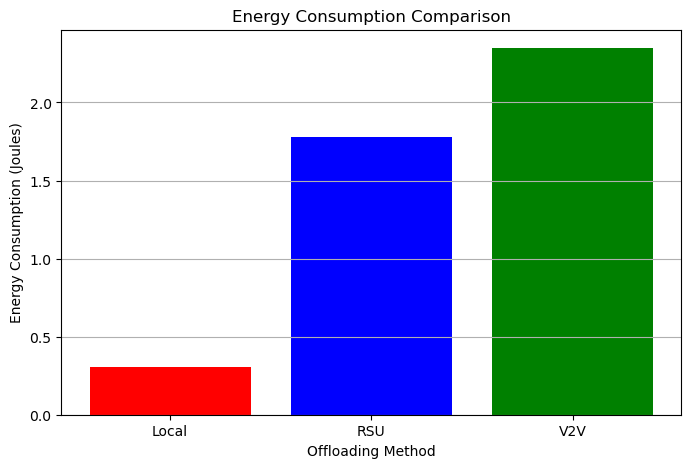

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
import random

# Load LSTM mobility predictions
predictions = np.load("test_predictions_batched1.npz")
true_positions = predictions['true']
predicted_positions = predictions['predicted']
predicted_positions_dict = dict(enumerate(predicted_positions))

# Constants
RSU_COVERAGE = 800  # meters
HANDOVER_AREA = 300  # meters
TASK_SIZE_RANGE = (1, 2)  # MB
CPU_CYCLES_PER_MB = 500  # cycles per MB
VEHICLE_CPU = 5000  # MHz
COOPERATIVE_VEHICLE_CPU = (20000, 100000)  # MHz range
RSU_CPU = (100000, 200000)  # MHz range
V2R_BANDWIDTH = 10  # MHz (LTE-V assumption)
V2V_BANDWIDTH = 5  # MHz (LTE-V assumption)
LEARNING_RATE = 0.0005  # Fine-tuned learning rate
GAMMA = 0.95  # Discount factor
EPSILON_DECAY = 0.995  # Epsilon decay rate
EPSILON_MIN = 0.1  # Minimum epsilon for exploration-exploitation

# Metrics tracking
episode_rewards = []
offloading_counts = {"Local": 0, "RSU": 0, "V2V": 0}
delays = {"Local": [], "RSU": [], "V2V": []}
energy_consumption = {"Local": [], "RSU": [], "V2V": []}

# Transmission delay calculation
def transmission_delay(task_size, bandwidth):
    return task_size * 8 / bandwidth

# Define Vehicle and RSU Classes
class MissionVehicle:
    def __init__(self, vehicle_id):
        self.vehicle_id = vehicle_id
        self.x, self.y = true_positions[vehicle_id]
        self.cpu = VEHICLE_CPU
        self.task_size = random.uniform(*TASK_SIZE_RANGE)
        self.task_cycles = self.task_size * CPU_CYCLES_PER_MB

    def update_position(self):
        if self.vehicle_id in predicted_positions_dict:
            self.x, self.y = predicted_positions_dict[self.vehicle_id]

    def local_processing_time(self):
        return self.task_cycles / self.cpu

class CooperativeVehicle:
    def __init__(self, vehicle_id):
        self.vehicle_id = vehicle_id
        self.x, self.y = true_positions[vehicle_id]
        self.cpu = random.randint(*COOPERATIVE_VEHICLE_CPU)

class RSU:
    def __init__(self, location):
        self.location = location
        self.cpu = random.randint(*RSU_CPU)

# DQN Model
class DQN:
    def __init__(self):
        self.memory = deque(maxlen=2000)
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()
        self.epsilon = 1.0  # Initial epsilon for exploration

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, input_dim=5, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(3, activation='linear')  # 3 actions: Local, RSU, V2V
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < 32:
            return
        batch = random.sample(self.memory, 32)
        for state, action, reward, next_state, done in batch:
            target = self.model.predict(np.array([state]), verbose=0)
            if done:
                target[0][action] = reward
            else:
                future_q = np.max(self.target_model.predict(np.array([next_state]), verbose=0))
                target[0][action] = reward + GAMMA * future_q
            self.model.fit(np.array([state]), target, epochs=1, verbose=0)

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(3)
        q_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])

# Simulation with Real Data Logging
def run_simulation():
    mission_vehicles = [MissionVehicle(i) for i in range(10)]
    cooperative_vehicles = [CooperativeVehicle(i) for i in range(5)]
    rsus = [RSU(1000), RSU(2000)]

    dqn = DQN()

    for episode in range(1000):
        total_reward = 0

        for mv in mission_vehicles:
            mv.update_position()
            state = [mv.task_size, mv.task_cycles, mv.x, mv.y, mv.cpu]
            action = dqn.act(state)

            if action == 0:  # Local processing
                delay = mv.local_processing_time()
                energy = delay * 2  # Example energy calculation
                reward = -delay - (0.5 * energy)
                offloading_counts["Local"] += 1
                delays["Local"].append(delay)
                energy_consumption["Local"].append(energy)

            elif action == 1:  # RSU Offloading
                delay = min([transmission_delay(mv.task_size, V2R_BANDWIDTH) + (mv.task_cycles / rsu.cpu) for rsu in rsus])
                energy = delay * 1.5
                reward = -delay - (0.5 * energy)
                offloading_counts["RSU"] += 1
                delays["RSU"].append(delay)
                energy_consumption["RSU"].append(energy)

            else:  # V2V Offloading
                delay = min([transmission_delay(mv.task_size, V2V_BANDWIDTH) + (mv.task_cycles / cv.cpu) for cv in cooperative_vehicles])
                energy = delay * 1
                reward = -delay - (0.5 * energy)
                offloading_counts["V2V"] += 1
                delays["V2V"].append(delay)
                energy_consumption["V2V"].append(energy)

            total_reward += reward
            next_state = state
            dqn.store_experience(state, action, reward, next_state, done=False)

        # Epsilon decay
        if dqn.epsilon > EPSILON_MIN:
            dqn.epsilon *= EPSILON_DECAY

        episode_rewards.append(total_reward)
        dqn.train()

        if episode % 50 == 0:
            dqn.update_target_model()
            print(f"Episode {episode} - Reward: {total_reward:.2f}")

    plot_results()

# Plot Results
def plot_results():
    plt.figure(figsize=(10, 5))
    plt.plot(range(1000), episode_rewards, marker='o', linestyle='-', label="Training Reward")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("DQN Training: Reward Over Episodes")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.pie(list(offloading_counts.values()), labels=list(offloading_counts.keys()), autopct='%1.1f%%', startangle=140)
    plt.title("Task Offloading Decision Distribution")
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.bar(list(delays.keys()), [np.mean(delays[k]) for k in delays], color=['red', 'blue', 'green'])
    plt.xlabel("Offloading Method")
    plt.ylabel("Average Delay (ms)")
    plt.title("Delay Comparison")
    plt.grid(axis='y')
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.bar(list(energy_consumption.keys()), [np.mean(energy_consumption[k]) for k in energy_consumption], color=['red', 'blue', 'green'])
    plt.xlabel("Offloading Method")
    plt.ylabel("Energy Consumption (Joules)")
    plt.title("Energy Consumption Comparison")
    plt.grid(axis='y')
    plt.show()

# Run the real integrated simulation
run_simulation()


In [15]:

predictions = np.load("test_predictions_batched.npz")
# Display the keys (names of arrays) in the npz file
print(predictions.keys())
# Check available keys in the file

KeysView(NpzFile 'test_predictions_batched.npz' with keys: true, predicted)


In [16]:
# Access the data using the key
true_positions = predictions['true']
predicted_positions = predictions['predicted']


In [17]:
# Print the whole array if it's not too large
print(true_positions)
print(predicted_positions)

# Or, print a small portion of the data to see the structure
print(true_positions[:5])  # Prints the first 5 rows of true_positions
print(predicted_positions[:5])  # Prints the first 5 rows of predicted_positions

# Check the shape of the data to understand its dimensions
print(true_positions.shape)
print(predicted_positions.shape)


[[0.29827116 0.36810257]
 [0.26373392 0.45852683]
 [0.2646164  0.45309072]
 ...
 [0.63928327 0.28701391]
 [0.28515138 0.70076751]
 [0.28464186 0.71035791]]
[[0.2987745  0.36391187]
 [0.26459652 0.45525753]
 [0.26558688 0.44814295]
 ...
 [0.63750005 0.28633   ]
 [0.28560263 0.6956857 ]
 [0.28432617 0.7055613 ]]
[[0.29827116 0.36810257]
 [0.26373392 0.45852683]
 [0.2646164  0.45309072]
 [0.40720714 0.29461049]
 [0.26152257 0.76316313]]
[[0.2987745  0.36391187]
 [0.26459652 0.45525753]
 [0.26558688 0.44814295]
 [0.4055535  0.29197612]
 [0.26090553 0.7570433 ]]
(7815, 2)
(7815, 2)


In [ ]:

predictions = np.load("test_predictions_batched.npz")
# Display the keys (names of arrays) in the npz file
print(predictions.keys())
# Check available keys in the file
# Access the data using the key
true_positions = predictions['true']
predicted_positions = predictions['predicted']
# Print the whole array if it's not too large
print(true_positions)
print(predicted_positions)

# Or, print a small portion of the data to see the structure
print(true_positions[:5])  # Prints the first 5 rows of true_positions
print(predicted_positions[:5])  # Prints the first 5 rows of predicted_positions

# Check the shape of the data to understand its dimensions
print(true_positions.shape)
print(predicted_positions.shape)

